In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame,Series

#Preprocessing
import nltk
import re
from  TextCleaner2000.TextCleaner import TextCleaner

#Machine  Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

#For interactive cluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

#Visuals
import matplotlib.pyplot as plt
import mpld3

In [2]:
#Load Data
wian_df=pd.read_csv('DATA.IN\\SBMA_PYTHON.csv')

In [6]:
#Use my stop word remove tool, and to normalize text for the tokens
#By Default TextCleaner assumes the TextCleaner folder is in same directory
# If this isn't true, pass fully-qualified location of TextCleaner folder as only argument
cleaner = TextCleaner()

In [7]:
#Remove non-alphanumeric characters and replace with blank
clean_list = cleaner.alpha_iterator(wian_df["TITLE"])

In [8]:
clean_list_beta= cleaner.stop_word_iterator(clean_list)

In [9]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passe

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [10]:
#Here, this is where my text cleaner comes in handy: we can pass a custom stop-word list
remove_words = ('sbma', 'spinal muscular',
                'spinal bulbar', 'spinal', 'muscular','atrophy', 'bulbar','spinal muscular atrophy', 
                'spinal bulbar muscular atrophy', "kennedy's", 'kennedy', 'disease', 'diseases', 'syndrome',
                'atrophy', 'kennedy-', 's', 'patient','type','bulbospinal','case','study','clinical','adult','family','patients',
                'disorders', 'report','bulbo','mouse','model','spinobulbar','analysis','disorders')

In [11]:
#Remove the custom stop-words. We want to know what is in the other 40% of articles, which is not disease name
titles = cleaner.custom_stop_word_iterator(clean_list_beta, remove_words)

In [12]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=200000,
                                 min_df=2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3), tokenizer=tokenize_only)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(titles) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 246 ms
(910, 1315)


In [13]:
#We will use these terms to define the words in the clusters
terms = tfidf_vectorizer.get_feature_names()

In [14]:
terms[0:10]

['aag',
 'aberrant',
 'abnormal',
 'abnormal androgen',
 'abnormal androgen receptor',
 'abnormalities',
 'abnormally',
 'absence',
 'accelerates',
 'accentuates']

In [15]:

# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(5)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(tfidf_matrix)

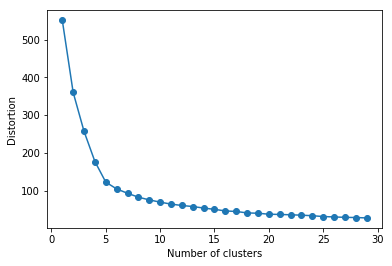

In [16]:
distortions=[]
for i in range(1,30):
    km=KMeans(n_clusters=i,
              init='random',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,30), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [101]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters, init='k-means++', n_init=300,random_state=0, max_iter=800)

%time km.fit(X)

clusters = km.labels_.tolist()

Wall time: 1.69 s


In [102]:
# We need a dissimilarity function to plot the points in the cluster
# We pass this function to the MDS algorithm and we get our x and y coordinates for the cluster 
dist = 1 - cosine_similarity(tfidf_matrix)
print()

In [103]:
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, metric=True, eps=1e-4, 
          max_iter = 750, n_init=30, n_jobs = -1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [104]:
# This gives us the words that are in each cluster

print("Top terms per cluster:")
print()
# sort cluster centers by proximity to centroid
# The centroids were transformed earlier. We need to transform back to original state from TFIDF
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

for i in range(num_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
            print()

Top terms per cluster:

Cluster 0: androgen
 motor
 neuron
 motor neuron
 receptor
 androgen receptor
 kennedys
 repeat
 gene
 polyglutamine
Cluster 1: kennedys
 motor
 neuron
 motor neuron
 xlinked
 androgen
 amyotrophic
 molecular
 lateral
 amyotrophic lateral sclerosis
Cluster 2: motor
 motor neuron
 neuron
 degeneration
 molecular
 kennedys
 genetics
 muscle
 neuron degeneration
 motor neuron degeneration
Cluster 3: xlinked
 recessive
 xlinked recessive
 neuronopathy
 xlinked recessive neuronopathy
 recessive neuronopathy
 kennedys
 xlinked neuronopathy
 sensory
 neuropathy
Cluster 4: lateral sclerosis
 amyotrophic lateral
 amyotrophic lateral sclerosis
 sclerosis
 amyotrophic
 lateral
 motor
 xlinked
 diagnosis
 cortical
Cluster 5: kennedys
 xlinked
 xlinked kennedys
 features
 muscle
 molecular
 diagnosis
 review
 cognitive
 involvement
Cluster 6: androgen
 receptor
 androgen receptor
 gene
 receptor gene
 androgen receptor gene
 repeat
 cag
 polyglutamine
 cag repeat
Cluster 7: 

In [105]:
cluster_names = {0: 'Polyglutamine Disease',
                 1: 'Molecular', 
                 2: 'X-Linked Recessive/Bulbo', 
                 3: 'Motor Neuron',
                 4:'Amyotrophic Lateral Sclerosis', 
                 5:'X-linked', 
                 6:'Androgen Receptor, CAG/Trinucleotide Repeat',
                 7:'CAG/Trinucleotide Repeat'
                }

In [106]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}


C:\Users\johnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


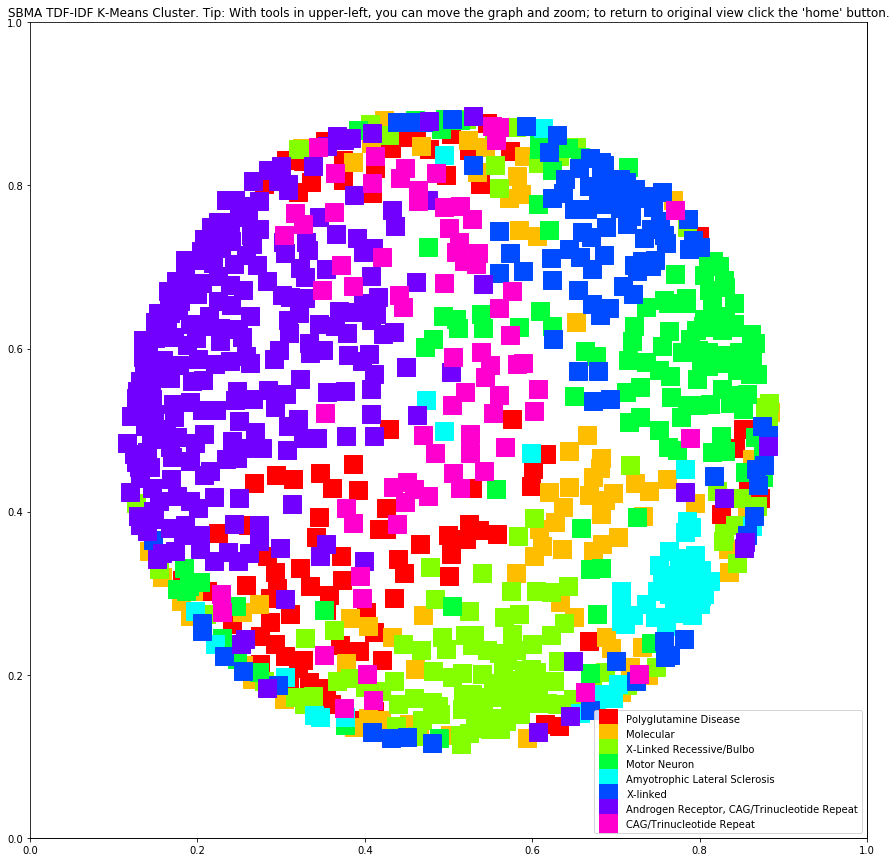

In [107]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=wian_df["TITLE"]) )

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}
background.mlpd3-background{

    background-color:black;
}
g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -50px;
margin-right: 50px;}
"""

NUM_COLORS =num_clusters

cm = plt.get_cmap('hsv') #hsv
# set up plot

fig, ax = plt.subplots(figsize=(15,15), sharex=True, sharey=True) # set size
ax = fig.add_subplot(111)
ax.margins(0.15) #ptional, just adds 5% padding to the autoscaling

ax.set_color_cycle([cm(i/NUM_COLORS) for i in range(NUM_COLORS)])

#1.*i/NUM_COLORS)
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='s', ms=18
                     ,linestyle='',
                     label=cluster_names[name], linewidth=.20)
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,voffset=40, hoffset=45,
                                        css=css) #

    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)

ax.legend(numpoints=1,loc="lower right") #show legend with only one dot

plt.title("SBMA TDF-IDF K-Means Cluster. Tip: With tools in upper-left, you can move the graph and zoom; to return to original view click the 'home' button.")



#mpld3.enable_notebook()
#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
mpld3.save_html(fig,"sbma.html")